TODO:  
- change the confidence plots of the learned curves (clicks and costs) like the reward (i.e. with np.std() over the samples )and not by making the mean of the gp stds 
  because confidence interval is not the confidence interval of the curve we get over the experiments, but the confidence of the GP with the assumption we made on it (kernel choice)
  The same applies for the convertion rate if we want to plot something like this
  Also, add the evolution in time for those plots in someway (like 3d plots or more plots in different time steps)
      
- add plot of the pulled arms in step 1

Changes wrt old version:
- UserClass class: click_function and cost_function attributes RENAMED with n_daily_clicks_function and cum_daily_costs_function respectively
- In Learner class: collected_rewards as list instead of an array
- In step 1: 
    To be consistent with step2 and step3
    - Environment class of step 1 as a wrapper of PricingEnvirnoment class
    - Custom_UCB_Learner and Custom_TS_Learner as as wrappers class of UCB1_Learner and UCB1_Learner respectively, instead of extending them (like in step2 and step3)


OBS:  
- sklearn.gaussian_process does not update in an online way, every new data it updates by fitting again all the points => it's slow  
    so, for now I'm just running the examples with T<100 and not so  number of experiments <50
     

In [22]:
import numpy as np
import matplotlib.pyplot as plt

#for GP
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, DotProduct

User Class

In [23]:
class UserClass:
    """
    F1 and F2: in {0,1}
        are the binary features
    n_daily_clicks_function: it is a function
        represents the number of clicks given a bid
    cum_daily_costs: it is a function
        represents the cost given a bid
    conversion_rate: a function with image in [0,1] (com: usually descendent)
        it represent how a user is likely to buy the product given a price
        Obs:
        |   in the text says to consider just 5 prices, maybe we can consider this as an array instead of a function
        |__

    """

    def __init__(self, F1, F2, n_daily_clicks_function, cum_daily_costs_function, conversion_rate_function):
        self.F1 = F1
        self.F2 = F2
        self.n_daily_clicks_function = n_daily_clicks_function
        self.cum_daily_costs_function = cum_daily_costs_function
        self.conversion_rate_function = conversion_rate_function



Basic Environments

In [24]:
class PricingEnvironment:

    def __init__(self, prices, margin, user_class):
        """
        PARAMETERS:
            prices: list or array of numbers
                it is the set of prices we will use, since we are discretizing the problem
                eg: an array of 5
            
            margin: int

            user_calss: UserClass type
        """
        self.n_arms = len(prices)
        self.prices = prices
        self.margin = margin
        # self.user_class = user_class
        self.convertion_probabilities = [user_class.conversion_rate_function(p) for p in prices]


    def round(self, pulled_arm, n_daily_clicks, cum_daily_costs):
        alpha = self.convertion_probabilities[pulled_arm]
        reward = np.random.binomial(n_daily_clicks, alpha) * self.margin - cum_daily_costs
        return reward

In [25]:
class BiddingEnvironment:#or maybe call it AdvertisingEnvironment
    def __init__(self, bids, sigma_clicks, sigma_costs, user_class):
        """
        n_arms: integer

        prices: array
            it is the set of prices we will use, since we are discretizing the problem
            eg: an array of 5
        """
        self.bids = bids
        # self.n_arms = len(bids)
        # self.user_class = user_class

        self.mean_clicks = [user_class.n_daily_clicks_function(b) for b in bids]
        self.mean_costs = [user_class.cum_daily_costs_function(b) for b in bids]

        self.sigmas_clicks = np.ones(len(bids)) * sigma_clicks
        self.sigmas_costs = np.ones(len(bids)) * sigma_costs


    def round(self, pulled_arm):
        n_daily_clicks = np.random.normal(self.mean_clicks[pulled_arm], self.sigmas_clicks[pulled_arm])
        cum_daily_costs = np.random.normal(self.mean_costs[pulled_arm], self.sigmas_costs[pulled_arm])

        return n_daily_clicks, cum_daily_costs

Basic Learners

In [26]:
class Learner:
    """
    Atributes:
    (....)
    rewards_per_arm: a list of list of dimension: number_of_arms x self.t

    (....)
    """

    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.t = 0 #current round
        self.rewards_per_arm = x = [[] for i in range(n_arms)]
        self.collected_rewards = []

    def pull_arm(self):
        pass

    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards.append(reward)

In [27]:
#### Basic MABs ####

class UCB1_Learner(Learner):
    def __init__(self, n_arms, support = (0,1)):
        """
        support: tuple
            the support interval of what we are learning
            e.g. in the case we are learning a probability p -> support = (0,1)
        """
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.confidence = np.full(n_arms, np.inf)
        self.c = (support[1] - support[0]) * np.sqrt(2)

    def pull_arm(self):
        upper_confidence = self.empirical_means + self.confidence
        idx = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])
        return idx

    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        
        #Model Updating:
        #-update mean
        self.empirical_means[pulled_arm] += (reward - self.empirical_means[pulled_arm]) / self.t
        # it's the same as: self.empirical_means[pulled_arm] = ((self.t - 1) * self.empirical_means[pulled_arm] + reward) / self.t

        #-update confidences
        for a in range(self.n_arms):
            n_samples = len(self.rewards_per_arm[a])
            if n_samples > 0:
                self.confidence[a] = self.c * np.sqrt(np.log(self.t)/n_samples)



class Binomial_TS_Learner(Learner):
    """
    Notes:
        - This algorithm learns p parameter of a binomial distribution (for each arm)
          assuming n is known (obs: n is the maximum value k can assume)
        - In this scenario the reward we observe is k

        Bayes:
            prior: P(p) = Beta(alpha, beta)
            likelihood: P(k|p;n) =  Binomial(n,p)
            ==> posterior: P(p|k;n) = Beta(alpha+k, beta+n-k)
    """
    def __init__(self, n_arms, n):
        super().__init__(n_arms)
        self.beta_parameters = np.ones((n_arms, 2))
        self.n = n

    def pull_arm(self):
        idx = np.argmax(np.random.beta( self.beta_parameters[:,0], self.beta_parameters[:,1] ))
        return idx

    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        self.beta_parameters[pulled_arm,0] = self.beta_parameters[pulled_arm,0] + reward
        self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1] + self.n - reward

In [50]:
## Basic GP-MABs

class GPUCB_Learner(Learner):
    def __init__(self, arms, kernel=None, alpha = 0.025):
        n_arms = len(arms)
        super().__init__(n_arms)

        self.arms = arms

        if kernel == None:
            kernel = ConstantKernel(1.0, (1e-4, 1e4)) * RBF(1.0, (1e-4, 1e4))#Obs: the hyperparamters will be optimized (changed) during learning by GaussianProcessRegressor class

        self.means = np.zeros(n_arms)
        self.sigmas = np.ones(n_arms)#np.full(n_arms, 1e3)#np.ones(n_arms)

        self.pulled_arms_x = []#here we will save the values of the pulled arms (not the indexes)
        #obs: actually, the information of the (arms pulled, reward) is there
        # e.g. [[i, self.rewards_per_arm[i]] for i in arms]
        # but creating another list is more processor efficient

        self.gp = GaussianProcessRegressor(kernel=kernel,
                                           alpha = alpha,
                                           n_restarts_optimizer = 5,# the higher the slower the run, try 4
                                           normalize_y=True)

    def update_observations(self, arm_idx, reward):
        super().update_observations(arm_idx, reward)
        self.pulled_arms_x.append([self.arms[arm_idx]])


    def pull_arm(self):
        upper_confidence = self.means + self.sigmas
        idx = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])
        return idx


    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        # update of the model:
        if len(self.collected_rewards) > 1:#at least 2 elements in our training set. (not sure why.. to update the kernel hyperparameters??)
            self.gp.fit(self.pulled_arms_x,self.collected_rewards)

        self.means, self.sigmas = self.gp.predict(np.array(self.arms).reshape((-1,1)), return_std=True)
        self.sigmas = np.maximum(self.sigmas, 1e-5)



class GPTS_Learner(Learner):
    def __init__(self, arms, kernel = None, alpha = 0.025):
        n_arms = len(arms)
        super().__init__(n_arms)
        self.arms = arms

        self.means = np.zeros(n_arms)#np.full(n_arms, 1e3)
        self.sigmas = np.ones(n_arms)#np.full(n_arms, 1e3)#np.ones(n_arms)

        self.pulled_arms_x = []#here we will save the values of the pulled arms (not the indexes)
        #obs: actually, the information of the (arms pulled, reward) is there
        # e.g. [[i, self.rewards_per_arm[i]] for i in arms]
        # but creating another list is more processor efficient

        if kernel == None:
            kernel = ConstantKernel(1.0, (1e-4, 1e4)) * RBF(1.0, (1e-4, 1e4))#Obs: the hyperparamters will be optimized (changed) during learning

        self.gp = GaussianProcessRegressor(kernel=kernel,
                                           alpha = alpha,
                                           n_restarts_optimizer = 5,#the higher the slower the run
                                           normalize_y=True)


    def update_observations(self, arm_idx, reward):
        super().update_observations(arm_idx, reward)

        self.pulled_arms_x.append([self.arms[arm_idx]])

    def pull_arm(self):
        sampled_values = np.random.normal(self.means, self.sigmas)
        idx = np.argmax(sampled_values)
        return idx

    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        # update of the model:
        if len(self.collected_rewards) > 1:#at least 2 elements in our training set. (not sure why.. to update the kernel hyperparameters??)
            self.gp.fit(self.pulled_arms_x, self.collected_rewards)

        self.means, self.sigmas = self.gp.predict(np.array(self.arms).reshape((-1,1)), return_std=True)
        self.sigmas = np.maximum(self.sigmas, 1e-3)

# Step 1

-we are just considering one class of users
<br>
-n and c are known
\
-alpha is unknown

### Environment

In [29]:
class Environment:
    def __init__(self, prices, margin, n_daily_clicks, cum_daily_costs, user_class):
        
        self.userclass = user_class #obs:python should take user_class by reference, so it's always the same UserClass object
        
        self.pricing_environment = PricingEnvironment(prices, margin, user_class)

        self.n_daily_clicks = max(round(n_daily_clicks), 0)#because negative number of clicks has no sense, also it gives error in np.random.binomial
        self.cum_daily_costs = cum_daily_costs

    def round(self, pulled_arm):
        reward = self.pricing_environment.round(pulled_arm, self.n_daily_clicks, self.cum_daily_costs)
        return reward

### Learners

Obs: here the arms are for the prices

In [30]:
class Custom_UCB_Learner(Learner):
    def __init__(self, arms_prices, n_daily_clicks, cum_daily_costs, margin):
        n_arms = len(arms_prices)
        super().__init__(n_arms)

        self.arms_prices = arms_prices
        self.n_daily_clicks = n_daily_clicks
        self.cum_daily_costs = cum_daily_costs
        self.margin = margin

        self.conversion_rate_learner = UCB1_Learner(n_arms)


    def pull_arm(self):
        # Obs:  the arm that maximizes the conversion rate is the one that maximizes the reward,
        #       so, the following arm is the arm we pull:
        idx_arm = self.conversion_rate_learner.pull_arm()
        
        return idx_arm


    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        
        alpha = (reward + self.cum_daily_costs) / (self.n_daily_clicks * self.margin)
        self.conversion_rate_learner.update(pulled_arm, alpha)

In [31]:
class Custom_TS_Learner(Learner):
    def __init__(self, arms_prices, n_daily_clicks, cum_daily_costs, margin):
        n_arms = len(arms_prices)
        super().__init__(n_arms)

        self.arms_prices = arms_prices
        self.n_daily_clicks = n_daily_clicks
        self.cum_daily_costs = cum_daily_costs
        self.margin = margin

        self.conversion_rate_learner = Binomial_TS_Learner(n_arms, n_daily_clicks)

    def pull_arm(self):
        # Obs:  the arm that maximizes the conversion rate is the one that maximizes the reward,
        #       so, the following arm is the arm we pull:
        idx_arm = self.conversion_rate_learner.pull_arm()
        
        return idx_arm


    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        k = (reward + self.cum_daily_costs) / self.margin
        self.conversion_rate_learner.update(pulled_arm, k)



## Example

In [32]:
F1 = 0
F2 = 0
def click_f(bid):
    bid_0 = 2
    bid_1 = 6
    max_clicks = 5

    # if bid < bid_0:
    #     return 0
    # elif bid < bid_1:
    #     return n_max * (bid - bid_0)/(bid_1-bid_0)
    # return n_max
    return (bid < bid_1) * (bid > bid_0) * (bid - bid_0)/(bid_1-bid_0) * max_clicks + (bid >= bid_1) * max_clicks



def cost_f(bid):
    return bid * 2

def conversion_rate_f(price):
    return np.exp(-price)

def conversion_rate_f(price):
    return np.exp(-price)

C1 = UserClass(F1, F2, click_f, cost_f, conversion_rate_f)

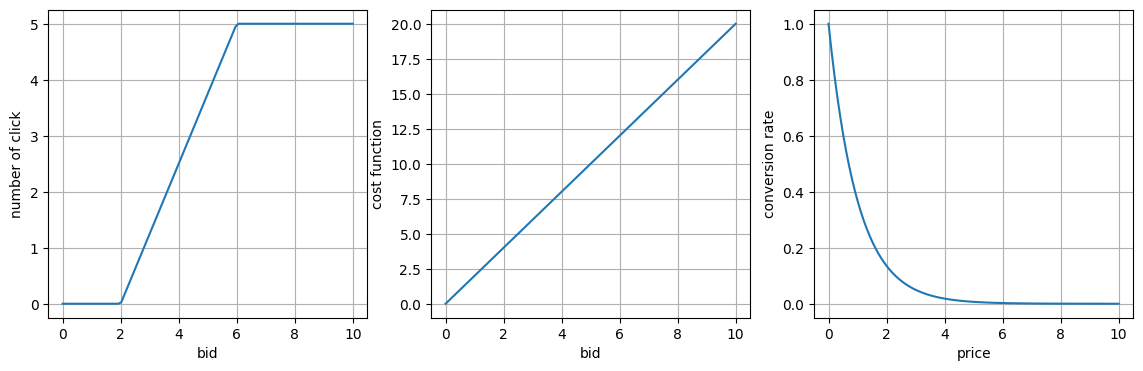

In [33]:
plt.figure(figsize=(14,4))

xx = np.linspace(0,10,100)
plt.subplot(1,3,1)
plt.plot(xx, click_f(xx))
plt.xlabel('bid')
plt.ylabel('number of click')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,2)
plt.plot(xx, cost_f(xx))
plt.xlabel('bid')
plt.ylabel('cost function')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,3)
plt.plot(xx, conversion_rate_f(xx))
plt.xlabel('price')
plt.ylabel('conversion rate')
plt.grid(True)

In [34]:
#Fixed parameters
n_arms = 5
T = 365

# in this step n_clicks and cost are given
# so let's fix a bid and compute n_clicks and cost
BID = 6
n_daily_clicks = int(C1.n_daily_clicks_function(BID))
cum_daily_costs = C1.cum_daily_costs_function(BID)

margin = 90


#setting the arms
prices = np.array([1,3,5,7,9])
opt_arm = np.argmax(C1.conversion_rate_function(prices)) #optimal value of convertion rate between the arms
opt = n_daily_clicks * C1.conversion_rate_function(prices[opt_arm]) * margin - cum_daily_costs


n_experiments = 1000

### UCB

In [35]:
## UCB learner

ucb_rewards_per_experiment = []

ucb_conversion_rate_hat = np.zeros(len(prices))
ucb_conversion_rate_bound = np.zeros(len(prices))

for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    env = Environment(prices, margin, n_daily_clicks, cum_daily_costs, C1)
    ucb_learner = Custom_UCB_Learner(prices, n_daily_clicks, cum_daily_costs, margin)

    # rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)
        
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

    ucb_conversion_rate_hat += ucb_learner.conversion_rate_learner.empirical_means/n_experiments
    ucb_conversion_rate_bound += ucb_learner.conversion_rate_learner.confidence/n_experiments

In [ ]:
# Plot of the conversion rate

#TODO: change this plot

# plt.figure()

# # plt.fill_between(prices, ucb_conversion_rate_hat - ucb_conversion_rate_bound, ucb_conversion_rate_hat + ucb_conversion_rate_bound, alpha = 0.2, color = 'C1')

# plt.plot(prices, C1.conversion_rate_function(prices), linestyle="dotted", label = "True function")

# plt.plot(prices, ucb_conversion_rate_hat)

# # COM: This confidence
# plt.fill_between(prices, ucb_conversion_rate_hat - ucb_conversion_rate_bound, ucb_conversion_rate_hat + ucb_conversion_rate_bound,
#                  alpha = 0.2, color="tab:orange", label=r"confidence")
# # has to be changed.

# plt.xlabel("price")
# plt.ylabel("alpha")
# plt.legend()

### Thompson Sampling

In [37]:
## TS learner

ts_rewards_per_experiment = []

ts_conversion_rate_hat = np.zeros(len(prices))
ts_conversion_rate_bound = np.zeros(len(prices))

for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    env = Environment(prices, margin, n_daily_clicks, cum_daily_costs, C1)
    ts_learner = Custom_TS_Learner(prices, n_daily_clicks, cum_daily_costs, margin)

    rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = ts_learner.pull_arm()
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)

### Plots both methods

In [38]:
ucb_std_inst = np.std(ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ucb_std_cum = np.std(np.cumsum(ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ucb_mean_rewards_hat = np.mean(ucb_rewards_per_experiment, axis = 0)


ts_std_inst = np.std(ts_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ts_std_cum = np.std(np.cumsum(ts_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ts_mean_rewards_hat = np.mean(ts_rewards_per_experiment, axis = 0)

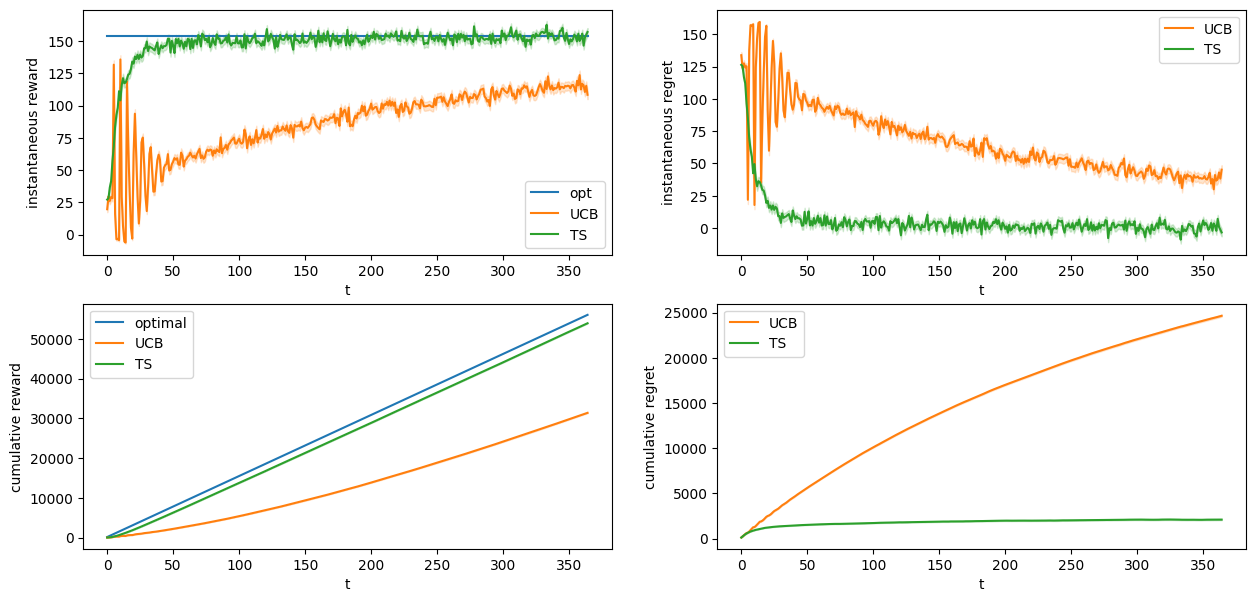

In [39]:
#Plots
plt.figure(figsize = (15,7))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "opt")
plt.plot(ucb_mean_rewards_hat, color = 'C1', label = "UCB")
plt.fill_between(np.arange(T), ucb_mean_rewards_hat - ucb_std_inst, ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(ts_mean_rewards_hat, color = 'C2', label = "TS")
plt.fill_between(np.arange(T), ts_mean_rewards_hat-ts_std_inst, ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - ucb_mean_rewards_hat, color = "C1", label = "UCB")
plt.fill_between(np.arange(T), opt - ucb_mean_rewards_hat - ucb_std_inst, opt - ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(opt - ts_mean_rewards_hat, color = "C2", label = "TS")
plt.fill_between(np.arange(T), opt - ts_mean_rewards_hat - ts_std_inst, opt - ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(ts_mean_rewards_hat) - ts_std_cum, np.cumsum(ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(opt - ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(opt - ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(opt - ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(opt - ts_mean_rewards_hat) - ts_std_cum, np.cumsum(opt - ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()

# Step 2

hp:
- just one class of users
- alpha is known
- n and c are unknown

OBS:I'm assuming that we can see both the number of clicks and the costs of the advertising (other than the reward)

About the learner: we are using 2 GP-Bandit learners one for the number of clicks and another one for the costs

### Environment

In [41]:
# class BiddingEnvironment:
#     def __init__(self, bids, user_class, sigma_clicks, sigma_costs):
#         """
#         n_arms: integer

#         prices: array
#             it is the set of prices we will use, since we are discretizing the problem
#             eg: an array of 5
#         """
#         # self.n_arms = len(bids)
#         self.bids = bids
#         self.user_class = user_class

#         self.mean_clicks = [user_class.n_daily_clicks_function(b) for b in bids]
#         self.mean_costs = [user_class.cum_daily_costs_function(b) for b in bids]

#         self.sigmas_clicks = np.ones(len(bids)) * sigma_clicks
#         self.sigmas_costs = np.ones(len(bids)) * sigma_costs


#     def round(self, margin, conversion_rate, pulled_arm):
#         #OBS:
#         n_daily_clicks = np.random.normal(self.mean_clicks[pulled_arm], self.sigmas_clicks[pulled_arm])
#         cum_daily_costs = np.random.normal(self.mean_costs[pulled_arm], self.sigmas_costs[pulled_arm])

#         alpha = conversion_rate # or "np.random.binomial(n_daily_clicks, conversion_rate)" ? imo this complicates the learning
#         reward = n_daily_clicks * alpha * margin - cum_daily_costs

#         return n_daily_clicks, cum_daily_costs, reward
    


    
class Environment:
    def __init__(self, bids, sigma_clicks, sigma_costs, conversion_rate, margin, user_class):
        self.userclass = user_class #obs:python should take by reference user_class, so it's always the same UserClass object
        self.margin = margin
        self.conversion_rate = conversion_rate

        self.bidding_environment = BiddingEnvironment(bids, sigma_clicks, sigma_costs, user_class)


    def round(self, pulled_arm):
        n_daily_clicks, cum_daily_costs = self.bidding_environment.round(pulled_arm)
        n_daily_clicks = max(round(n_daily_clicks), 0)
        
        reward = n_daily_clicks * self.conversion_rate * self.margin - cum_daily_costs
        # or  reward = np.random.binomial(n_daily_clicks, conversion_rate) * margin - cum_daily_cost  ??? 
        # Obviously this should incerease the variability

        return n_daily_clicks, cum_daily_costs, reward

### Learners

GPUCB

In [42]:
class Custom_GPUCB_Learner(Learner):
    def __init__(self, arms_bids, conversion_rate, margin):
        n_arms_bids = len(arms_bids)
        super().__init__(n_arms_bids)

        self.arms_bids = arms_bids

        self.conversion_rate = conversion_rate
        self.margin = margin

        self.n_daily_clicks_learner = GPUCB_Learner(arms_bids)
        self.cum_daily_costs_learner = GPUCB_Learner(arms_bids)


    def pull_arm(self):
        #upper bounds of clicks and lower bounds of costs
        ub_clicks = self.n_daily_clicks_learner.means + self.n_daily_clicks_learner.sigmas
        lb_costs = self.cum_daily_costs_learner.means - self.cum_daily_costs_learner.sigmas

        upper_confidence = ub_clicks * self.conversion_rate * self.margin - lb_costs
        idx = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])
        return idx

    def update(self, pulled_arm, n_daily_clicks, cum_daily_costs, reward):
        # com: actually the reward is computable: reward = n_daily_clicks * self.convertion_rate * self.margin - cum_daily_costs,
        #       but this assuming that the reward is in expectation wrt to conversion, 
        #       maybe it is reward = np.random.binomial(n_daily_clicks, self.convertion_rate) * self.margin - cum_daily_costs,
        #       (depends on what the environment does)
        self.t += 1
        self.update_observations(pulled_arm, reward)

        self.n_daily_clicks_learner.update(pulled_arm, n_daily_clicks)
        self.cum_daily_costs_learner.update(pulled_arm, cum_daily_costs)

GPTS

In [44]:
class Custom_GPTS_Learner(Learner):
    def __init__(self, arms_bids, conversion_rate, margin):
        n_arms_bids = len(arms_bids)
        super().__init__(n_arms_bids)

        self.conversion_rate = conversion_rate
        self.margin = margin

        self.n_daily_clicks_learner = GPTS_Learner(arms_bids)
        self.cum_daily_costs_learner = GPTS_Learner(arms_bids)

    def pull_arm(self):
        sampled_clicks = np.random.normal(self.n_daily_clicks_learner.means, self.n_daily_clicks_learner.sigmas)
        sampled_costs = np.random.normal(self.cum_daily_costs_learner.means, self.cum_daily_costs_learner.sigmas)

        alpha = self.conversion_rate
        idx = np.argmax(sampled_clicks * alpha * self.margin - sampled_costs)
        return idx

    def update(self, pulled_arm, n_daily_clicks, cum_daily_costs, reward):
        # com: actually the reward is computable: reward = n_daily_clicks * self.convertion_rate * self.margin - cum_daily_costs,
        #       but this assuming that the reward is in expectation wrt to conversion, 
        #       maybe it is reward = np.random.binomial(n_daily_clicks, self.convertion_rate) * self.margin - cum_daily_costs
        #       (depends on what the environment does)
        self.t += 1
        self.update_observations(pulled_arm, reward)

        self.n_daily_clicks_learner.update(pulled_arm, n_daily_clicks)
        self.cum_daily_costs_learner.update(pulled_arm, cum_daily_costs)

## Example

In [45]:
F1 = 0
F2 = 0
def click_f(bid):
    bid_0 = 2
    bid_1 = 6
    max_clicks = 5

    # if bid < bid_0:
    #     return 0
    # elif bid < bid_1:
    #     return n_max * (bid - bid_0)/(bid_1-bid_0)
    # return n_max
    return (bid < bid_1) * (bid > bid_0) * (bid - bid_0)/(bid_1-bid_0) * max_clicks + (bid >= bid_1) * max_clicks

def cost_f(bid):
    return bid * 2

def conversion_rate_f(price):
    return np.exp(-price)

def conversion_rate_f(price):
    return np.exp(-price)

C1 = UserClass(F1, F2, click_f, cost_f, conversion_rate_f)

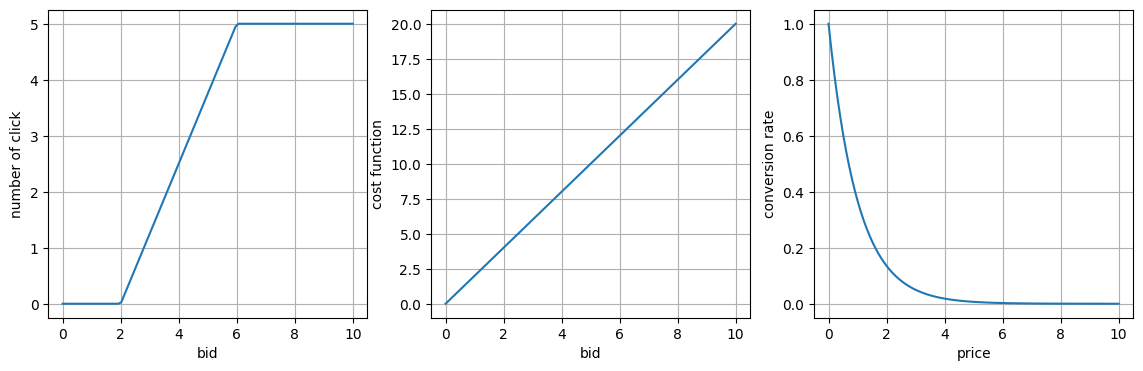

In [46]:
plt.figure(figsize=(14,4))

xx = np.linspace(0,10,100)
plt.subplot(1,3,1)
plt.plot(xx, click_f(xx))
plt.xlabel('bid')
plt.ylabel('number of click')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,2)
plt.plot(xx, cost_f(xx))
plt.xlabel('bid')
plt.ylabel('cost function')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,3)
plt.plot(xx, conversion_rate_f(xx))
plt.xlabel('price')
plt.ylabel('conversion rate')
plt.grid(True)

Parameters

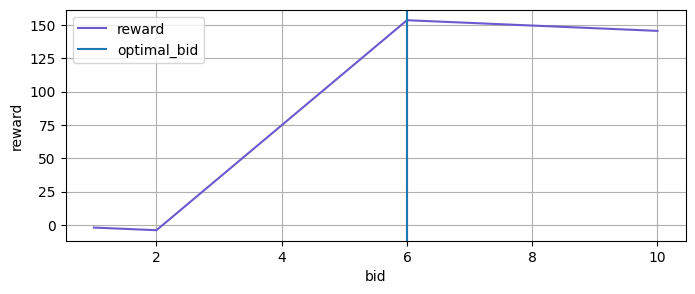

In [55]:
#Fixed parameters
T = 80#100#365

# in this step the optimal price for the conversion rate is given,
# so let's fix the price and compute the related conversion rate
PRICE = 1
conversion_rate = C1.conversion_rate_function(PRICE)

# margin
margin = 90

# sigmas
sigma_clicks = 0.5
sigma_costs = 0.3

#setting the arms
bids = np.linspace(1,10,100)

rewards_on_arms = C1.n_daily_clicks_function(bids) * conversion_rate * margin - C1.cum_daily_costs_function(bids)
opt_arm = np.argmax(rewards_on_arms) #optimal value of convertion rate between the arms
opt = rewards_on_arms[opt_arm]




n_experiments = 50#20




plt.figure(figsize=(8,3))
plt.plot(bids, rewards_on_arms, "slateblue")
plt.axvline(bids[opt_arm])
plt.xlabel('bid')
plt.ylabel('reward')
plt.legend(["reward","optimal_bid"])
plt.grid(True)

### UCB

In [56]:
## UCB learner

gpucb_rewards_per_experiment = []

gpucb_n_daily_clicks_hat = np.zeros(len(bids))
gpucb_n_daily_clicks_std = np.zeros(len(bids))

gpucb_cum_daily_costs_hat = np.zeros(len(bids))
gpucb_cum_daily_costs_std = np.zeros(len(bids))

# #to count the arms that are pulled
gpucb_pulled_arms_counter = np.zeros(len(bids))

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(bids, sigma_clicks, sigma_costs, conversion_rate, margin, C1)
    gpucb_learner = Custom_GPUCB_Learner(bids,conversion_rate, margin)

    for t in range(0, T):
        pulled_arm = gpucb_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, reward = env.round(pulled_arm)
        gpucb_learner.update(pulled_arm, n_daily_clicks, cum_daily_costs, reward)
        
    gpucb_rewards_per_experiment.append(gpucb_learner.collected_rewards)

    mean_prediction, std_prediction = gpucb_learner.n_daily_clicks_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    gpucb_n_daily_clicks_hat += mean_prediction / n_experiments
    gpucb_n_daily_clicks_std += std_prediction  / n_experiments

    mean_prediction, std_prediction = gpucb_learner.cum_daily_costs_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    gpucb_cum_daily_costs_hat += mean_prediction / n_experiments
    gpucb_cum_daily_costs_std += std_prediction  / n_experiments

    gpucb_pulled_arms_counter += np.array([len(rewards_i) for rewards_i in gpucb_learner.rewards_per_arm]) / n_experiments

0.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


2.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


4.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


6.0%
8.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-pac

10.0%
12.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


14.000000000000002%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


16.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


18.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site

20.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


22.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


24.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


26.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site

28.000000000000004%
30.0%
32.0%
34.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


36.0%
38.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


40.0%
42.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


44.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\sit

46.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


48.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


50.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\sit

52.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


54.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


56.00000000000001%
57.99999999999999%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60.0%
62.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


64.0%
66.0%
68.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


70.0%
72.0%
74.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


76.0%
78.0%
80.0%
82.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


84.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


86.0%
88.0%
90.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


92.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\sit

94.0%
96.0%
98.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site

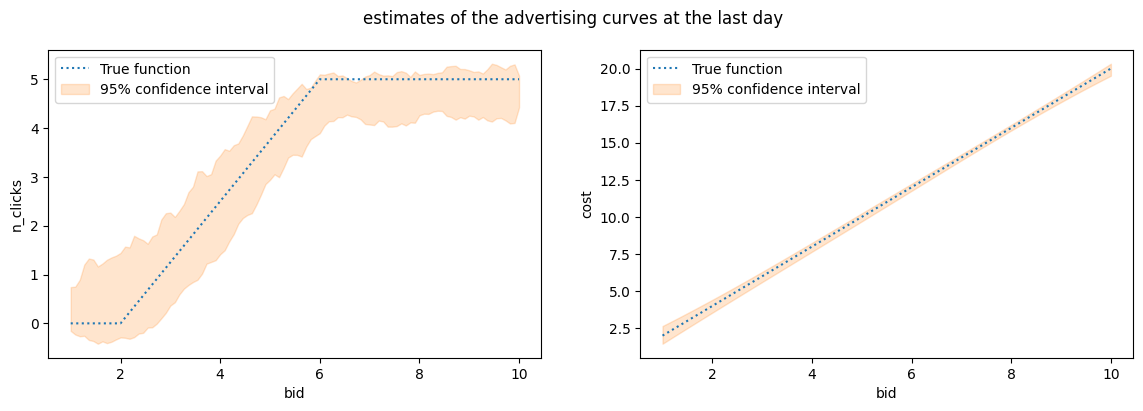

In [57]:
# Plots of the estimates of the functions clicks and costs at the last day

#TODO change confidence plot and add something time related

plt.figure(figsize = (14,4))
plt.suptitle('estimates of the advertising curves at the last day')

plt.subplot(1,2,1)
plt.plot(bids,C1.n_daily_clicks_function(bids), linestyle="dotted", label = "True function")
# plt.plot(bids, gpucb_n_daily_clicks_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, gpucb_n_daily_clicks_hat - 1.96 *gpucb_n_daily_clicks_std, gpucb_n_daily_clicks_hat + 1.96*gpucb_n_daily_clicks_std,
                 alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
plt.xlabel("bid")
plt.ylabel("n_clicks")
plt.legend()

plt.subplot(1,2,2)
plt.plot(bids,C1.cum_daily_costs_function(bids), linestyle="dotted", label = "True function")
# plt.plot(bids, gpucb_cum_daily_costs_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, gpucb_cum_daily_costs_hat - 1.96 *gpucb_cum_daily_costs_std, gpucb_cum_daily_costs_hat + 1.96*gpucb_cum_daily_costs_std,
                 alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
plt.xlabel("bid")
plt.ylabel("cost")
plt.legend()

Text(0, 0.5, 'times pulled')

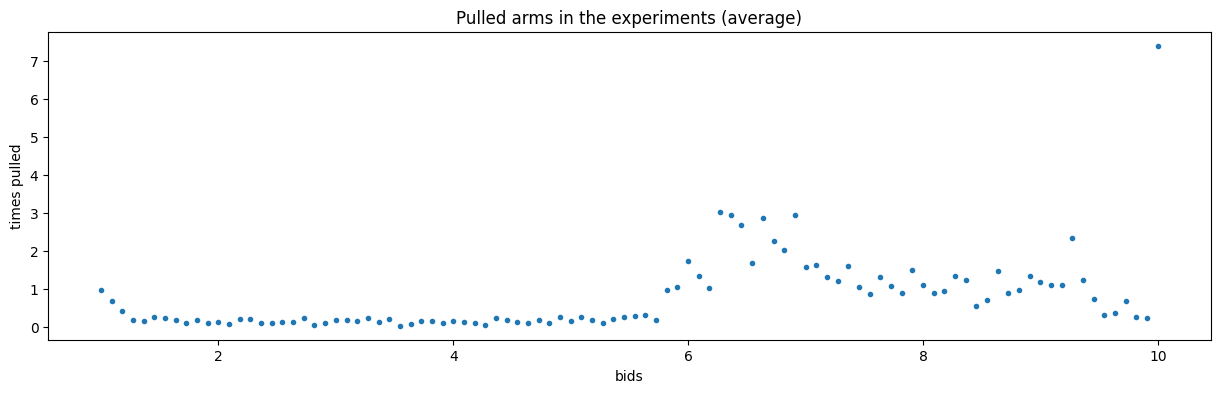

In [58]:
# Plot: Pulled arms
#TODO add something time related to this plot

plt.figure(figsize=(15,4))
plt.title("Pulled arms in the experiments (average)")
plt.plot(bids, gpucb_pulled_arms_counter, '.', color = "C0")
plt.xlabel("bids")
plt.ylabel("times pulled")

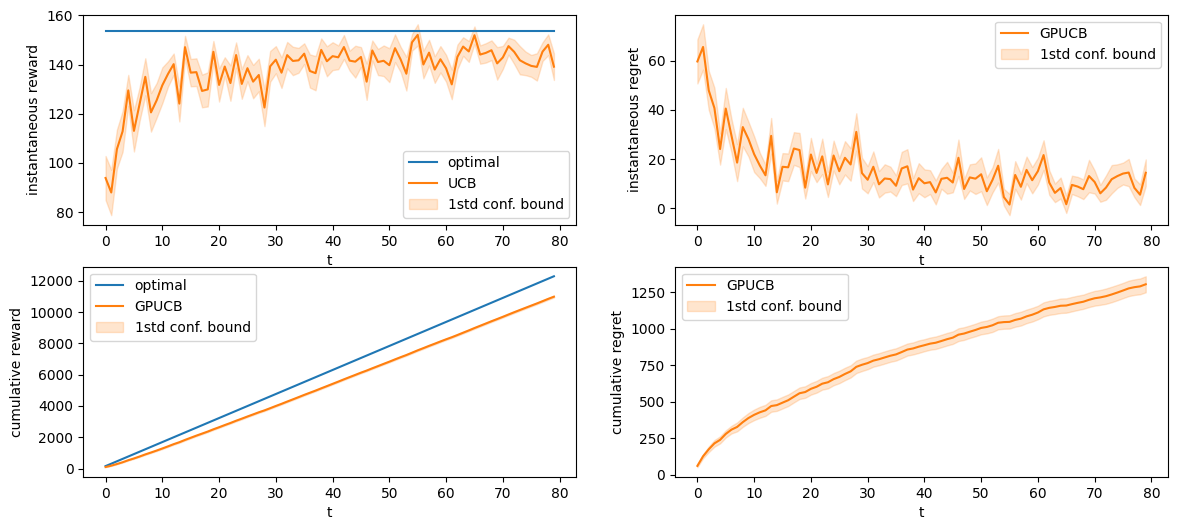

In [59]:
std_inst = np.std(gpucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(gpucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(gpucb_rewards_per_experiment, axis = 0)

#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "GPUCB")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "GPUCB")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "GPUCB")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### Thompson sampling

In [60]:
## TS learner

gpts_rewards_per_experiment = []

gpts_n_daily_clicks_hat = np.zeros(len(bids))
gpts_n_daily_clicks_std = np.zeros(len(bids))

gpts_cum_daily_costs_hat = np.zeros(len(bids))
gpts_cum_daily_costs_std = np.zeros(len(bids))

# #to count the arms that are pulled
gpts_pulled_arms_counter = np.zeros(len(bids))

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(bids, sigma_clicks, sigma_costs, conversion_rate, margin, C1)
    gpts_learner = Custom_GPTS_Learner(bids, conversion_rate, margin)

    for t in range(0, T):
        pulled_arm = gpts_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, reward = env.round(pulled_arm)
        gpts_learner.update(pulled_arm, n_daily_clicks, cum_daily_costs, reward)

    gpts_rewards_per_experiment.append(gpts_learner.collected_rewards)

    mean_prediction, std_prediction = gpts_learner.n_daily_clicks_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    gpts_n_daily_clicks_hat += mean_prediction / n_experiments
    gpts_n_daily_clicks_std += std_prediction  / n_experiments

    mean_prediction, std_prediction = gpts_learner.cum_daily_costs_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    gpts_cum_daily_costs_hat += mean_prediction / n_experiments
    gpts_cum_daily_costs_std += std_prediction  / n_experiments

    # #counting the pulled arms
    gpts_pulled_arms_counter += np.array([len(rewards_i) for rewards_i in gpts_learner.rewards_per_arm]) / n_experiments

0.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


2.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


4.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


6.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


8.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


10.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-pac

12.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


14.000000000000002%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


16.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-p

18.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-pac

20.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


22.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


24.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


26.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-pac

28.000000000000004%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


30.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


32.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


34.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


36.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-pac

38.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


40.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


42.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


44.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


46.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


48.0%
50.0%
52.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


54.0%
56.00000000000001%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


57.99999999999999%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-

60.0%
62.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


64.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


66.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


68.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-p

70.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


72.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-pac

74.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-pac

76.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-pac

78.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site

80.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


82.0%
84.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-pac

86.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


88.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-pac

90.0%
92.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-pac

94.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


96.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


98.0%


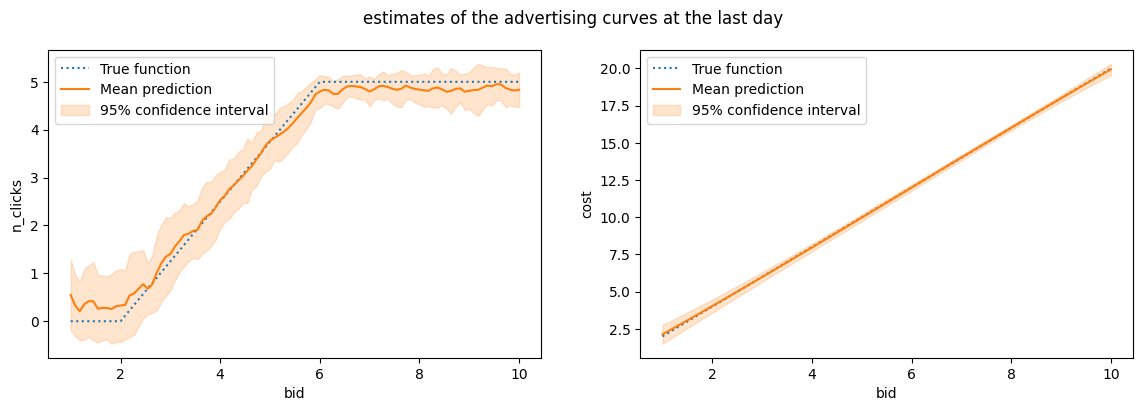

In [61]:
# Plots of the estimates of the functions clicks and costs at the last day

# TODO change the confidence and add something time related
plt.figure(figsize = (14,4))
plt.suptitle('estimates of the advertising curves at the last day')

plt.subplot(1,2,1)
plt.plot(bids,C1.n_daily_clicks_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, gpts_n_daily_clicks_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, gpts_n_daily_clicks_hat - 1.96 *gpts_n_daily_clicks_std, gpts_n_daily_clicks_hat + 1.96*gpts_n_daily_clicks_std,
                 alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
plt.xlabel("bid")
plt.ylabel("n_clicks")
plt.legend()

plt.subplot(1,2,2)
plt.plot(bids,C1.cum_daily_costs_function(bids), linestyle="dotted", label = "True function")
plt.plot(bids, gpts_cum_daily_costs_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, gpts_cum_daily_costs_hat - 1.96 *gpts_cum_daily_costs_std, gpts_cum_daily_costs_hat + 1.96*gpts_cum_daily_costs_std,
                 alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
plt.xlabel("bid")
plt.ylabel("cost")
plt.legend()


Text(0, 0.5, 'times pulled')

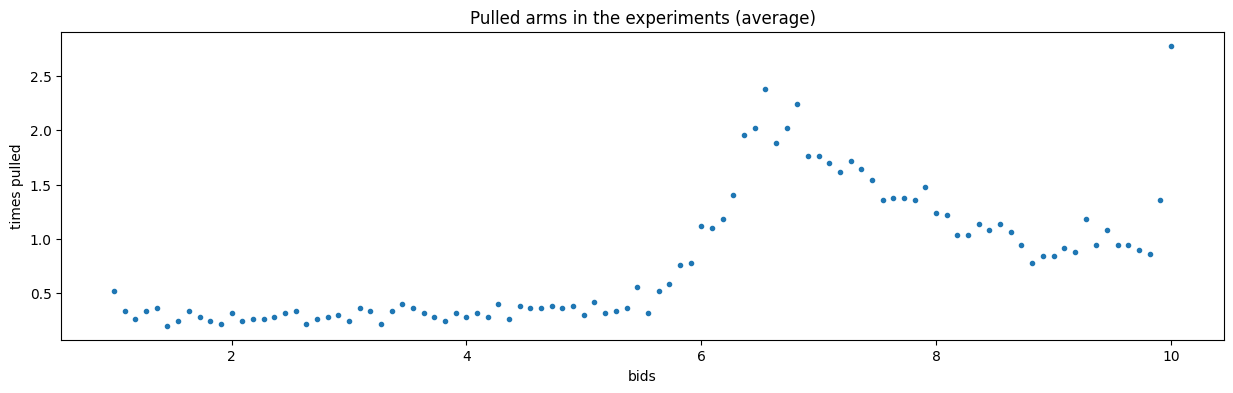

In [62]:
#TODO add something time related

plt.figure(figsize=(15,4))
plt.title("Pulled arms in the experiments (average)")
plt.plot(bids, gpts_pulled_arms_counter, '.', color = "C0")
plt.xlabel("bids")
plt.ylabel("times pulled")

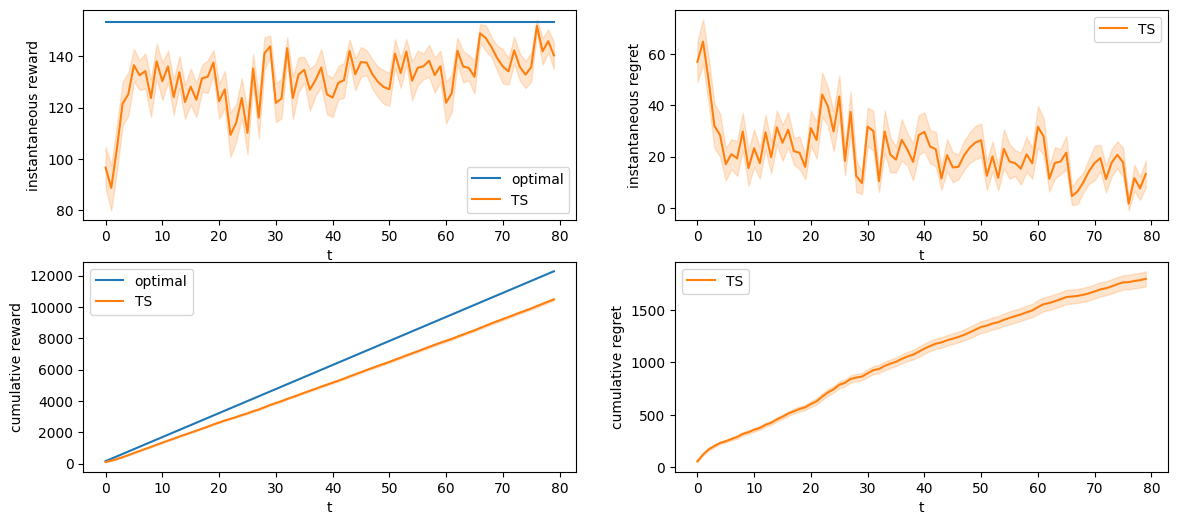

In [63]:
std_inst = np.std(gpts_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(gpts_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(gpts_rewards_per_experiment, axis = 0)

#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt))
plt.plot(mean_rewards_hat, 'C1')
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1')
plt.legend(["optimal","TS"])

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1')
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1')
plt.legend(["TS"])



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)))
plt.plot(np.cumsum(mean_rewards_hat), 'C1')
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1')
plt.legend(["optimal","TS"])

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1')
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1')
plt.legend(["TS"])

### Plots both methods

In [64]:
ucb_std_inst = np.std(gpucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ucb_std_cum = np.std(np.cumsum(gpucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ucb_mean_rewards_hat = np.mean(gpucb_rewards_per_experiment, axis = 0)


ts_std_inst = np.std(gpts_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ts_std_cum = np.std(np.cumsum(gpts_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

ts_mean_rewards_hat = np.mean(gpts_rewards_per_experiment, axis = 0)

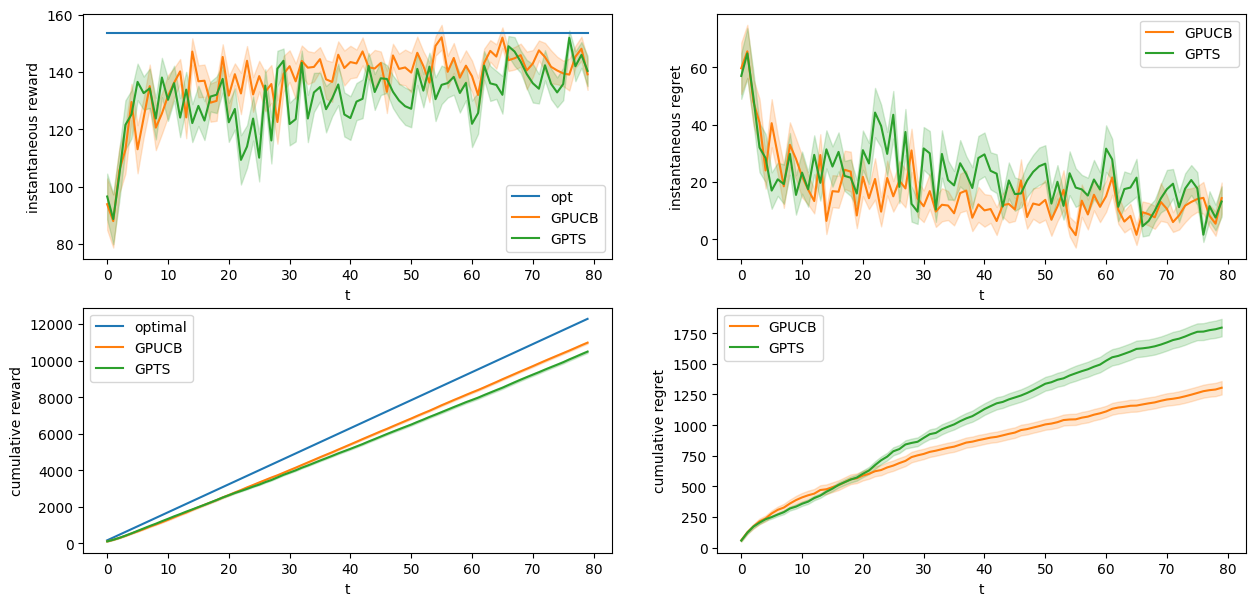

In [65]:
#Plots
plt.figure(figsize = (15,7))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "opt")
plt.plot(ucb_mean_rewards_hat, color = 'C1', label = "GPUCB")
plt.fill_between(np.arange(T), ucb_mean_rewards_hat - ucb_std_inst, ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(ts_mean_rewards_hat, color = 'C2', label = "GPTS")
plt.fill_between(np.arange(T), ts_mean_rewards_hat-ts_std_inst, ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - ucb_mean_rewards_hat, color = "C1", label = "GPUCB")
plt.fill_between(np.arange(T), opt - ucb_mean_rewards_hat - ucb_std_inst, opt - ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(opt - ts_mean_rewards_hat, color = "C2", label = "GPTS")
plt.fill_between(np.arange(T), opt - ts_mean_rewards_hat - ts_std_inst, opt - ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(ucb_mean_rewards_hat), color = "C1", label = "GPUCB")
plt.fill_between(np.arange(T), np.cumsum(ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(ts_mean_rewards_hat), color = "C2", label = "GPTS")
plt.fill_between(np.arange(T), np.cumsum(ts_mean_rewards_hat) - ts_std_cum, np.cumsum(ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - ucb_mean_rewards_hat), color = "C1", label = "GPUCB")
plt.fill_between(np.arange(T), np.cumsum(opt - ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(opt - ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(opt - ts_mean_rewards_hat), color = "C2", label = "GPTS")
plt.fill_between(np.arange(T), np.cumsum(opt - ts_mean_rewards_hat) - ts_std_cum, np.cumsum(opt - ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()

# Step 3

**Framework**:  
just one class,  
alpha, n and c are unknown

### Environment

In [66]:
class Environment:
    def __init__(self, bids, prices, sigma_clicks, sigma_costs, margin, user_class):
        self.userclass = user_class

        self.bidding_environment = BiddingEnvironment(bids, sigma_clicks, sigma_costs, user_class)
        self.pricing_environment = PricingEnvironment(prices, margin, user_class)


    def round(self, pulled_arm_bid, pulled_arm_price):
        n_daily_clicks, cum_daily_costs = self.bidding_environment.round(pulled_arm_bid)
        n_daily_clicks = max(int(n_daily_clicks), 0)
        reward = self.pricing_environment.round(pulled_arm_price, n_daily_clicks, cum_daily_costs)

        return n_daily_clicks, cum_daily_costs, reward

## Learners

the reward function in expectation is  
reward(bid,price) = n_daily_clicks(bid) * alpha(price) * margin - cum_daily_costs(bid)

OBS:  
classic bandits for pricing  
GP bandits for advertising

### UCB based

In [67]:
class Custom_S3_UCB_Learner(Learner):# Obs: the curve of n_clicks and cost are always the same for any price we put, and the conversion rate is always the same for any bid we put
    def __init__(self, arms_bids, arms_prices, margin):
        self.n_arms_bids = len(arms_bids)
        self.n_arms_prices = len(arms_prices)
        super().__init__(self.n_arms_bids * self.n_arms_prices)

        self.arms_prices = arms_prices
        self.arms_bids = arms_bids

        self.margin = margin

        #learners:
        self.n_daily_clicks_learner = GPUCB_Learner(arms_bids)
        self.cum_daily_costs_learner = GPUCB_Learner(arms_bids)
        self.conversion_rate_learner = UCB1_Learner(self.n_arms_prices)


    def pull_arm(self):
        """
        Notes:
            The higher the conversion rate the higher the reward => I can pull directly the an arm of the prices for the highest alpha,
            while the clicks and costs I have to evaluate them together and pull the bid that maximizes the reward

            Question:
                Once I know the price arm to be pulled, for the bid arm, should I consider the upperbound of the conversion rate or just the mean of the conversion rate?
                -   choosing the mean of the conversion rate, there is just the uncertainty of related to the bid and the advertising curves
                -   choosing the upperbound of the conversion rate, it adds uncertainty related to the problem "conversion_rate(price)"
                --> I'm using the upperbound choice [but still an open question]
        """
        idx_price_arm = self.conversion_rate_learner.pull_arm()

        ub_clicks = self.n_daily_clicks_learner.means + self.n_daily_clicks_learner.sigmas
        lb_costs = self.cum_daily_costs_learner.means - self.cum_daily_costs_learner.sigmas

        ub_convertion_rate = self.conversion_rate_learner.empirical_means[idx_price_arm] + self.conversion_rate_learner.confidence[idx_price_arm]

        upper_confidence = ub_clicks * ub_convertion_rate * self.margin - lb_costs
        idx_bid_arm = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])

        return (idx_bid_arm, idx_price_arm)


    def flatten_index(self, idx_bid_arm,idx_price_arm):
        #e.g.: if len(bids) = 10, len(prices) = 3
        #   (0,2) --> 2
        #   (1,0) --> 1*3 = 3
        #   (5,2) --> 5*3 + 2 = 17
        idx = self.n_arms_prices * idx_bid_arm + idx_price_arm
        return idx


    def update(self, pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, reward):
        """"
        Obs: if n_daily_clicks = 0, we do not update the conversion_rate_learner
        """

        self.t += 1
        self.update_observations(self.flatten_index(pulled_arm_bid, pulled_arm_price), reward)

        self.n_daily_clicks_learner.update(pulled_arm_bid, n_daily_clicks)
        self.cum_daily_costs_learner.update(pulled_arm_bid, cum_daily_costs)

        if n_daily_clicks > 0:
            alpha = (reward + cum_daily_costs) / (n_daily_clicks * self.margin)
            self.conversion_rate_learner.update(pulled_arm_price, alpha)
            #should we increase self.conversion_rate_learner.t? self.conversion_rate_learner.t += 1
            # for now, we are not


### TS based

In [ ]:
class Custom_S3_GPTS_Learner(Learner):
    def __init__(self, arms_bids, arms_prices, margin):
        self.n_arms_bids = len(arms_bids)
        self.n_arms_prices = len(arms_prices)
        super().__init__(self.n_arms_bids * self.n_arms_prices)

        self.arms_prices = arms_prices
        self.arms_bids = arms_bids
        self.margin = margin

        #learners
        self.n_daily_clicks_learner = GPTS_Learner(arms_bids)
        self.cum_daily_costs_learner = GPTS_Learner(arms_bids)
        self.conversion_rate_learner = Binomial_TS_Learner(self.n_arms_prices)

    def pull_arm(self):
        idx_price_arm = self.conversion_rate_learner.pull_arm()

        sampled_clicks = np.random.normal(self.n_daily_clicks_learner.means, self.n_daily_clicks_learner.sigmas)
        sampled_costs = np.random.normal(self.cum_daily_costs_learner.means, self.cum_daily_costs_learner.sigmas)

        alpha = self.conversion_rate_learner #not sure about that??
        idx_bid_arm = np.argmax(sampled_clicks * alpha * self.margin - sampled_costs)
        
        return (idx_bid_arm, idx_price_arm)
    
    def flatten_index(self, idx_bid_arm,idx_price_arm):
        #e.g.: if len(bids) = 10, len(prices) = 3
        #   (0,2) --> 2
        #   (1,0) --> 1*3 = 3
        #   (5,2) --> 5*3 + 2 = 17
        idx = self.n_arms_prices * idx_bid_arm + idx_price_arm
        return idx

    def update(self, pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, reward):
        """"
        Obs: if n_daily_clicks = 0, we do not update the conversion_rate_learner
        """

        self.t += 1
        self.update_observations(self.flatten_index(pulled_arm_bid, pulled_arm_price), reward)

        self.n_daily_clicks_learner.update(pulled_arm_bid, n_daily_clicks)
        self.cum_daily_costs_learner.update(pulled_arm_bid, cum_daily_costs)

        if n_daily_clicks > 0:
            alpha = (reward + cum_daily_costs) / (n_daily_clicks * self.margin)
            self.conversion_rate_learner.update(pulled_arm_price, alpha)
            #should we increase self.conversion_rate_learner.t? self.conversion_rate_learner.t += 1
            #for now, we are not


## Example

In [68]:
F1 = 0
F2 = 0
def click_f(bid):
    bid_0 = 2
    bid_1 = 6
    max_clicks = 5

    # if bid < bid_0:
    #     return 0
    # elif bid < bid_1:
    #     return n_max * (bid - bid_0)/(bid_1-bid_0)
    # return n_max

    return (bid < bid_1) * (bid > bid_0) * (bid - bid_0)/(bid_1-bid_0) * max_clicks + (bid >= bid_1) * max_clicks



def cost_f(bid):
    return bid * 2

def conversion_rate_f(price):
    return np.exp(-price)

def conversion_rate_f(price):
    return np.exp(-price)

C1 = UserClass(F1, F2, click_f, cost_f, conversion_rate_f)

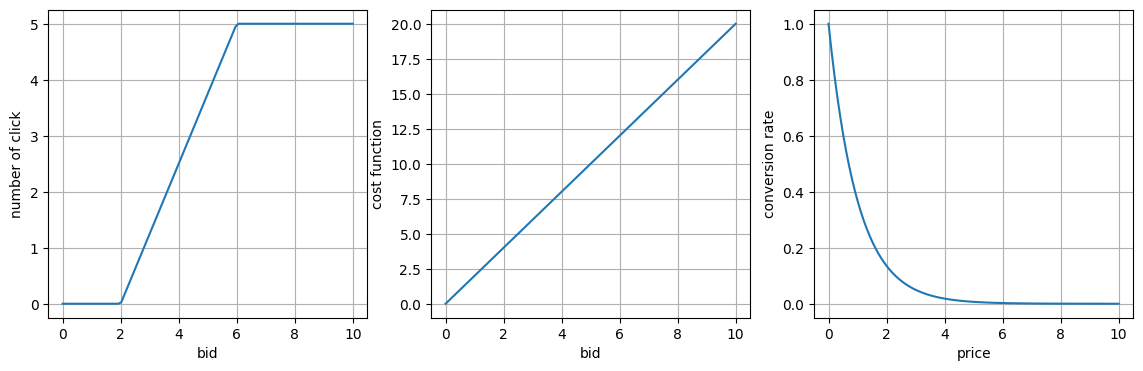

In [69]:
plt.figure(figsize=(14,4))

xx = np.linspace(0,10,100)
plt.subplot(1,3,1)
plt.plot(xx, click_f(xx))
plt.xlabel('bid')
plt.ylabel('number of click')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,2)
plt.plot(xx, cost_f(xx))
plt.xlabel('bid')
plt.ylabel('cost function')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,3)
plt.plot(xx, conversion_rate_f(xx))
plt.xlabel('price')
plt.ylabel('conversion rate')
plt.grid(True)

Parameters

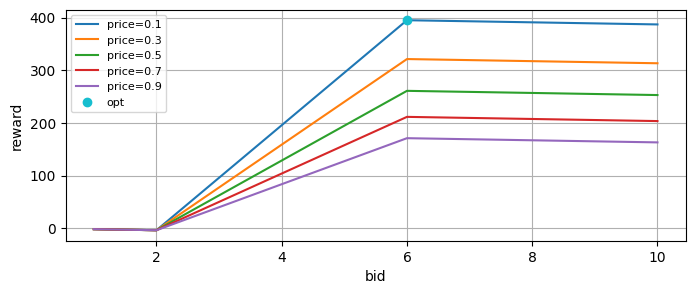

In [70]:
#Fixed parameters
T = 100#365

# in this step the optimal price for the conversion rate is given,
# so let's fix the price and compute the releated conversion rate

# margin
margin = 90

# sigmas
sigma_clicks = 0.5
sigma_costs = 0.3

#setting the arms
bids = np.linspace(1,10,100)
prices =  np.array([1,3,5,7,9]) / 10 #np.array([1,3,5,7,9])


opt_arm_price = np.argmax(C1.conversion_rate_function(prices)) #optimal value of convertion rate between the arms
opt_price = prices[opt_arm_price]

opt_conversion_rate = C1.conversion_rate_function(opt_price)

opt_bid_arm = np.argmax(C1.n_daily_clicks_function(bids) * opt_conversion_rate * margin - C1.cum_daily_costs_function(bids)) #optimal value of convertion rate between the arms
opt_bid = bids[opt_bid_arm]

opt_n_daily_clicks = C1.n_daily_clicks_function(opt_bid)
opt_cum_daily_costs = C1.cum_daily_costs_function(opt_bid)


opt = opt_n_daily_clicks * opt_conversion_rate * margin - opt_cum_daily_costs


n_experiments = 50




plt.figure(figsize=(8,3))
for price in prices:
    plt.plot(bids, C1.n_daily_clicks_function(bids) * C1.conversion_rate_function(price) * margin - C1.cum_daily_costs_function(bids), label = f'price={price}')
plt.plot(opt_bid, opt, 'o', color = "C9", label = "opt")
plt.xlabel('bid')
plt.ylabel('reward')
plt.legend(fontsize=8)
plt.grid(True)

### UCB

In [71]:
## UCB learner

ucb_rewards_per_experiment = []

ucb_n_daily_clicks_hat = np.zeros(len(bids))
ucb_n_daily_clicks_std = np.zeros(len(bids))

ucb_cum_daily_costs_hat = np.zeros(len(bids))
ucb_cum_daily_costs_std = np.zeros(len(bids))

# #to count the arms that are pulled
ucb_pulled_arms_counter = np.zeros(len(bids)*len(prices))

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(bids, prices, sigma_clicks, sigma_costs, margin, C1)
    ucb_learner = Custom_S3_UCB_Learner(bids, prices, margin)

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price = ucb_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, reward = env.round(pulled_arm_bid, pulled_arm_price)
        ucb_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, reward)

    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)


    mean_prediction, std_prediction = ucb_learner.n_daily_clicks_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    ucb_n_daily_clicks_hat += mean_prediction / n_experiments
    ucb_n_daily_clicks_std += std_prediction  / n_experiments

    mean_prediction, std_prediction = ucb_learner.cum_daily_costs_learner.gp.predict(bids.reshape((-1,1)), return_std=True)
    ucb_cum_daily_costs_hat += mean_prediction / n_experiments
    ucb_cum_daily_costs_std += std_prediction  / n_experiments

    # #counting the pulled arms
    ucb_pulled_arms_counter += np.array([len(rewards_i) for rewards_i in ucb_learner.rewards_per_arm]) / n_experiments

0.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


2.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


4.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


6.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


8.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


10.0%
12.0%
14.000000000000002%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


16.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-pac

18.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


20.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


22.0%
24.0%
26.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


28.000000000000004%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


30.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


32.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-pac

34.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


36.0%
38.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-pac

40.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


42.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


44.0%
46.0%
48.0%
50.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


52.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-

54.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


56.00000000000001%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


57.99999999999999%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-pac

60.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


62.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


64.0%
66.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


68.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


70.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


72.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


74.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


76.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


78.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


80.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


82.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-pac

84.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


86.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-

88.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-p

90.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


92.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


94.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


96.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-pac

98.0%


c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\oswal\anaconda3\envs\my-env\lib\site-pac

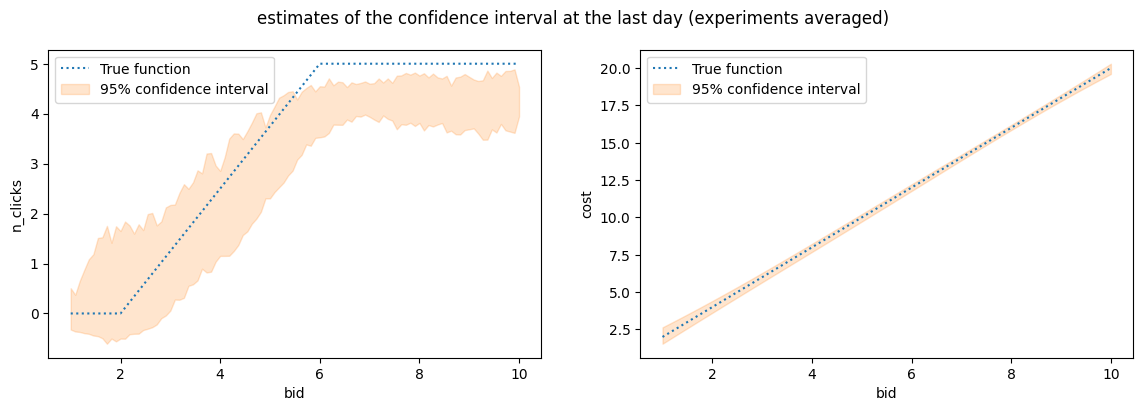

In [72]:
## Plots of the estimates of the functions clicks and costs at the last day
#TODO change the confidence and add something time related

plt.figure(figsize = (14,4))
plt.suptitle('estimates of the confidence interval at the last day (experiments averaged)')

plt.subplot(1,2,1)
plt.plot(bids,C1.n_daily_clicks_function(bids), linestyle="dotted", label = "True function")
# plt.plot(bids, ucb_n_daily_clicks_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, ucb_n_daily_clicks_hat - 1.96 * ucb_n_daily_clicks_std, ucb_n_daily_clicks_hat + 1.96 * ucb_n_daily_clicks_std,
                 alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
plt.xlabel("bid")
plt.ylabel("n_clicks")
plt.legend()

plt.subplot(1,2,2)
plt.plot(bids,C1.cum_daily_costs_function(bids), linestyle="dotted", label = "True function")
# plt.plot(bids, ucb_cum_daily_costs_hat, color = "C1",label="Mean prediction")
plt.fill_between(bids, ucb_cum_daily_costs_hat - 1.96 * ucb_cum_daily_costs_std, ucb_cum_daily_costs_hat + 1.96 * ucb_cum_daily_costs_std,
                 alpha = 0.2, color="tab:orange", label=r"95% confidence interval")
plt.xlabel("bid")
plt.ylabel("cost")
plt.legend()

In [ ]:
## Plot: conversion rate
# We can add a plot about the conversion rate #
# TODO

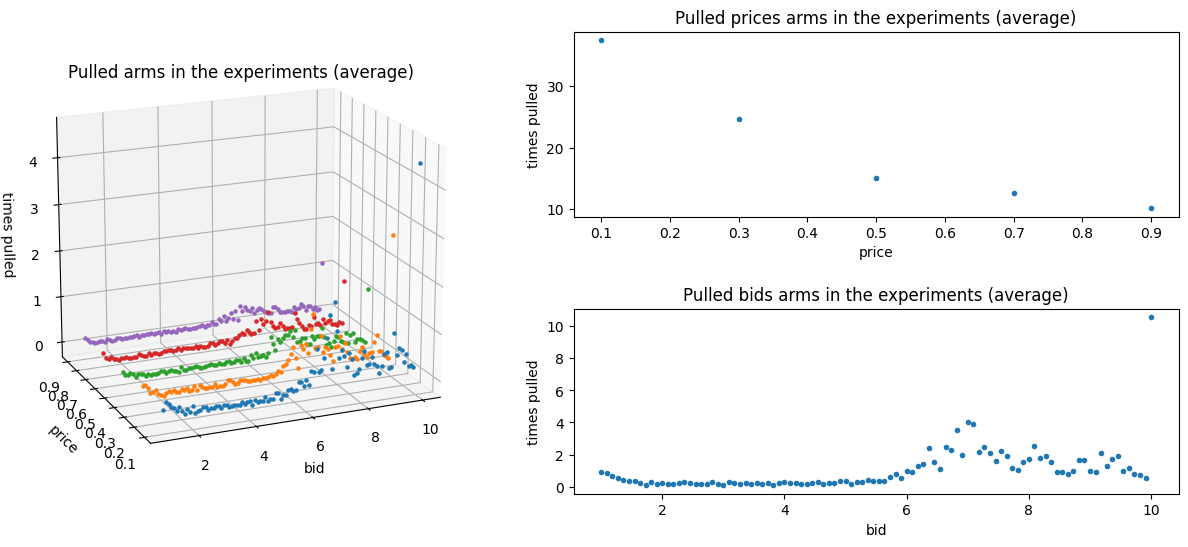

In [73]:
#TODO: add something time related
zz = np.reshape(ucb_pulled_arms_counter, (len(bids),len(prices)))

fig = plt.figure(figsize = (16,6))

ax = fig.add_subplot(2,2,2)
ax.set_title("Pulled prices arms in the experiments (average)")
ax.plot(prices, np.sum(zz, axis = 0), '.', color = "C0")
ax.set_xlabel('price')
ax.set_ylabel('times pulled')

ax = fig.add_subplot(2,2,4)
ax.set_title("Pulled bids arms in the experiments (average)")
ax.plot(bids, np.sum(zz, axis = 1), '.', color = "C0")
ax.set_xlabel('bid')
ax.set_ylabel('times pulled')

ax = fig.add_subplot(1,2,1, projection='3d')
zz = np.reshape(ucb_pulled_arms_counter, (len(bids),len(prices)))
for i,bid in enumerate(bids):
    for j,price in enumerate(prices):
        ax.scatter(bid, price, zz[i,j], marker = '.', color = f'C{j}')#color = 'C0'
ax.set_title('Pulled arms in the experiments (average)', y = 0.96)
ax.view_init(18, -113)
ax.set_xlabel('bid')
ax.set_ylabel('price')
ax.set_zlabel('times pulled')
ax.set_box_aspect(aspect=(1.2,1,1), zoom=1)

fig.subplots_adjust(wspace = 0.05, hspace = 0.5)#left=None, bottom=-.1, right=None, top=1.1,

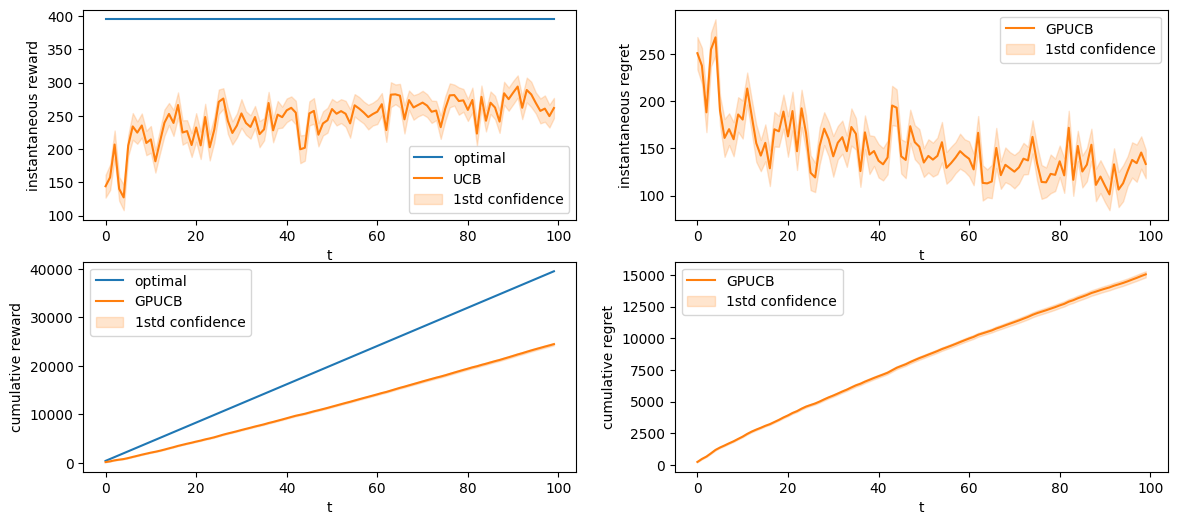

In [75]:
std_inst = np.std(ucb_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(ucb_rewards_per_experiment, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(ucb_rewards_per_experiment, axis = 0)

#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "GPUCB")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "GPUCB")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "GPUCB")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### TS

In [ ]:
# TODO

### Plots both methods

In [ ]:
# TODO
# TODO after TS

# Step 4

# Step 5

# Step 6